# Import

In [4]:
import os
import re
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import scipy.fft as fft
from sklearn.neighbors import KNeighborsClassifier as Knn
from sklearn.decomposition import PCA
import mahotas as mt


# Пути
Задать путь до обучающего каталога, и тестового 

In [5]:
path_to_train = '.\\pictures'
path_to_test = '.\\pictures'

# Получение обучающей и тестовой выборок

In [6]:
def get_train_photos(path_to_db, photos):
    dirs = os.listdir(path_to_db)
    photos_list = os.listdir(os.path.join(path_to_db, dirs[0]))
    photos_dict = dict([(int(re.search(r'\d+', photo).group(0)) - 1, photo) for photo in photos_list])
    train_photos = [photos_dict[i] for i in photos]
    return train_photos

In [7]:
def get_test_photos(path_to_db, photos):
    dirs = os.listdir(path_to_db)
    photos_list = os.listdir(os.path.join(path_to_db, dirs[0]))
    photos_dict = dict([(int(re.search(r'\d+', photo).group(0)) - 1, photo) for photo in photos_list])
    test_photos = []
    for i, photo in photos_dict.items():
        if i not in photos:
            test_photos.append(photo)
    return test_photos

In [8]:
def get_train_set2(path_to_db, method, parameter):
    dirs = os.listdir(path_to_db)
    photos = get_train_photos(path_to_db, range(16))
    X = []
    Y = []
    for dir in dirs:
        label = int(re.search(r'\d+', dir).group(0))
        x = []
        y = []
        for photo_name in photos:
            photo_path = os.path.join(path_to_db, dir, photo_name)
            vec = method(photo_path, parameter)
            x.append(vec)
            y.append(label)
        X.append(x)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

def get_train_set(classifier):
    dirs = os.listdir(classifier.path_to_db)
    train_photos = get_train_photos(classifier.path_to_db, classifier.photos)
    X = []
    y = []
    for dir in dirs:
        label = int(re.search(r'\d+', dir).group(0))
        for photo_name in train_photos:
            photo_path = os.path.join(classifier.path_to_db, dir, photo_name)
            vec = classifier.method(photo_path, classifier.parameter)
            X.append(vec)
            y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

# Вспомогательные функции

In [9]:
def count_distance(center, point):
    return ((center[0] - point[0])**2 + (center[1] - point[1])**2)**(1/2)

In [10]:
def count_error(pred, real):
    return np.sum(pred == real) / real.shape[0]

In [11]:
def count_precision(classifier, path_to_db, photos):
    y = []
    pred_all = []
    dirs = os.listdir(path_to_db)
    test_photos = get_test_photos(path_to_db, photos)
    for dir in dirs:
        label = int(re.search(r'\d+', dir).group(0))
        for photo_name in test_photos:
            photo_path = os.path.join(path_to_db, dir, photo_name)
            pred = classifier.predict(photo_path)
            pred_all.append(pred)
            y.append(label)

    pred_all = np.array(pred_all)
    y = np.array(y)
    precision = count_error(pred_all, y)
    return precision

# Методы

In [12]:
def hist(path, param, use_plot=False):
        img = cv.imread(path)
        img = cv.resize(img, (50, 50), interpolation= cv.INTER_LINEAR)
        histRange = (0, 256)
        accumulate = False
        hist = cv.calcHist([img], [0, 1, 2], None, [param, param, param], 
                           [0, 256, 0, 256, 0, 256], accumulate=accumulate).ravel()
        if use_plot:
            plt.hist(img.ravel(), param, histRange, rwidth=0.75)
        # else:
        #     hist = cv.calcHist([img], [0, 1, 2], None, [self.parameter], histRange, accumulate=accumulate).ravel()
        return hist

In [13]:
def pca(path, param, use_plot=False):
    img = cv.imread(path, 0)
    img = cv.resize(img, (100, 100), interpolation= cv.INTER_LINEAR)
    pca_ = PCA(param)

    transform = pca_.fit_transform(img)

    return transform.ravel()


In [14]:
def haralick(path, param, use_plot=False):
    img = cv.imread(path)
    # setting gaussian filter
    gaussian = mt.gaussian_filter(img, param)
    
    # setting threshold value
    gaussian = (gaussian > gaussian.mean())
    
    # making is labelled image
    labeled, n = mt.label(gaussian)
    
    # getting haralick features
    h_feature = mt.features.haralick(labeled).mean(axis=0)
    return h_feature

In [15]:
METHODS = {
    0: hist,
    1: pca,
    2: haralick
}

# Классифифкатор

In [16]:
class Classifier:
    def __init__(self, method, parameter, path_to_db, photos):
        self.classifier = Knn(1)
        self.parameter = parameter
        self.path_to_db = path_to_db
        self.photos = photos
        self.photos_names = get_train_photos(path_to_db, photos)
        self.n = len(photos)
        self.method = method

    def fit(self):
        train_images, train_labels = get_train_set(self)
        self.classifier.fit(train_images, train_labels)
        return self

    def predict(self, path, show_nearest=False):
        vec = self.method(path, self.parameter)
        X = [vec]
        pred = self.classifier.predict(X)[0]
        if show_nearest:
            self.draw_predict(path)
        return pred

    def draw_predict(self, path):
        self.get_plot(path)
        plt.show()
        # plt.savefig("predict.png")
        # img = cv.imread("predict.png", cv.IMREAD_COLOR)
        # cv.imshow("Predict", img)

    def get_plot(self, path):
        photo = cv.imread(path)
        photo = cv.cvtColor(photo, cv.COLOR_BGR2RGB)
        vec = self.method(path)
        X = [vec]

        nearest = self.classifier.kneighbors(X, return_distance=False)
        nearest = nearest[0, 0]
        pred_class = nearest // self.n
        pred_num_photo = nearest % self.n

        dirs = os.listdir(self.path_to_db)
        pred_dir = dirs[pred_class]
        pred_class_name = int(pred_dir)
        pred_photo_name = self.photos_names[pred_num_photo]
        pred_path_photo = os.path.join(self.path_to_db, pred_dir, pred_photo_name)
        pred_photo = cv.imread(pred_path_photo)
        pred_photo = cv.cvtColor(pred_photo, cv.COLOR_BGR2RGB)
        plt.subplot(121)
        plt.title(f"Original")
        plt.imshow(photo)
        plt.xticks([])
        plt.yticks([])
        plt.subplot(122)
        plt.title(f"Predicted, class {pred_class_name}")
        plt.imshow(pred_photo)
        plt.xticks([])
        plt.yticks([])

In [17]:
def fit(path_to_db, param, photos, method):
    if method == 'hist':
        classifier = Classifier(hist, param, path_to_db, photos)
    elif method == 'pca':
        classifier = Classifier(pca, param, path_to_db, photos)
    elif method == 'haralick':
        classifier = Classifier(haralick, param, path_to_db, photos)
    classifier.fit()
    
    precision = count_precision(classifier, path_to_db, photos)
    return classifier, precision

In [18]:
def fit_and_optimize(path_to_db, method_num, params, photos, draw=False):
    best_param = params[0]
    max_precision = 0.
    precision_arr = []
    best_classifier = None
    for param in range(params[0], params[1]+1):
        classifier, precision = fit(path_to_db, method_num, param, photos, 'hist')
        precision_arr.append(precision)
        if max_precision < precision:
            best_param = param
            best_classifier = classifier
            max_precision = precision
    if draw:
        fig, ax = plt.subplots()
        ax.set_title('Точность классификатора в зависимости от параметра')
        ax.plot(range(params[0], params[1]+1), precision_arr)
        ax.grid()
        ax.set_xlabel('Значение параметра')
        ax.set_ylabel('Точность')
        plt.savefig('precision.png')
        precision_img = cv.imread('precision.png', cv.IMREAD_COLOR)
        cv.imshow("Precision", precision_img)
    return best_classifier, best_param, max_precision

In [22]:
def clear_fit(train_set, train_labels, test_set, test_labels, path_to_db, param, photos, method):
    if method == 'hist':
        classifier = Classifier(hist, param, path_to_db, photos)
    elif method == 'pca':
        classifier = Classifier(pca, param, path_to_db, photos)
    elif method == 'haralick':
        classifier = Classifier(haralick, param, path_to_db, photos)
    classifier.classifier.fit(train_set, train_labels)

    pred = classifier.classifier.predict(test_set)
    precision = count_error(pred, test_labels)
    return classifier, precision

In [23]:
NUM_PHOTOS = 15

def find_best_params(path_to_db, params, method):
    best_params = np.zeros(NUM_PHOTOS)
    max_precisions = np.zeros(NUM_PHOTOS)
    # data = np.zeros((len(range(params[0], params[1]+1)), NUM_PHOTOS))
    for param in params:
        set, labels = get_train_set2(path_to_db, method, param)
        for num_photos in range(1, NUM_PHOTOS + 1):
            print(f"{num_photos}   {param}")
            photos = range(num_photos)
            train_set = set[:,:num_photos, :].reshape((-1, set.shape[2]))
            train_labels = labels[:,:num_photos].ravel()
            test_set = set[:,num_photos:, :].reshape((-1, set.shape[2]))
            test_labels = labels[:,num_photos:].ravel()
            classifier, precision = clear_fit(train_set, train_labels, test_set, test_labels, path_to_db, param, photos, method='hist')
            if max_precisions[num_photos-1] < precision:
                best_params[num_photos-1] = param
                max_precisions[num_photos-1] = precision

    return best_params, max_precisions

In [24]:
best_params_hist, precision_hist = find_best_params(path_to_train, range(3, 16), METHODS[0])

1   3
2   3
3   3
4   3
5   3
6   3
7   3
8   3
9   3
10   3
11   3
12   3
13   3
14   3
15   3
1   4
2   4
3   4
4   4
5   4
6   4
7   4
8   4
9   4
10   4
11   4
12   4
13   4
14   4
15   4
1   5
2   5
3   5
4   5
5   5
6   5
7   5
8   5
9   5
10   5
11   5
12   5
13   5
14   5
15   5
1   6
2   6
3   6
4   6
5   6
6   6
7   6
8   6
9   6
10   6
11   6
12   6
13   6
14   6
15   6
1   7
2   7
3   7
4   7
5   7
6   7
7   7
8   7
9   7
10   7
11   7
12   7
13   7
14   7
15   7
1   8
2   8
3   8
4   8
5   8
6   8
7   8
8   8
9   8
10   8
11   8
12   8
13   8
14   8
15   8
1   9
2   9
3   9
4   9
5   9
6   9
7   9
8   9
9   9
10   9
11   9
12   9
13   9
14   9
15   9
1   10
2   10
3   10
4   10
5   10
6   10
7   10
8   10
9   10
10   10
11   10
12   10
13   10
14   10
15   10
1   11
2   11
3   11
4   11
5   11
6   11
7   11
8   11
9   11
10   11
11   11
12   11
13   11
14   11
15   11
1   12
2   12
3   12
4   12
5   12
6   12
7   12
8   12
9   12
10   12
11   12
12   12
13   12
14   12
15 

In [206]:
best_params_pca, precision_pca = find_best_params(path_to_train, range(10, 100, 10), METHODS[1])

1   10
2   10
3   10
4   10
5   10
6   10
7   10
8   10
9   10
10   10
11   10
12   10
13   10
14   10
15   10
1   20
2   20
3   20
4   20
5   20
6   20
7   20
8   20
9   20
10   20
11   20
12   20
13   20
14   20
15   20
1   30
2   30
3   30
4   30
5   30
6   30
7   30
8   30
9   30
10   30
11   30
12   30
13   30
14   30
15   30
1   40
2   40
3   40
4   40
5   40
6   40
7   40
8   40
9   40
10   40
11   40
12   40
13   40
14   40
15   40
1   50
2   50
3   50
4   50
5   50
6   50
7   50
8   50
9   50
10   50
11   50
12   50
13   50
14   50
15   50
1   60
2   60
3   60
4   60
5   60
6   60
7   60
8   60
9   60
10   60
11   60
12   60
13   60
14   60
15   60
1   70
2   70
3   70
4   70
5   70
6   70
7   70
8   70
9   70
10   70
11   70
12   70
13   70
14   70
15   70
1   80
2   80
3   80
4   80
5   80
6   80
7   80
8   80
9   80
10   80
11   80
12   80
13   80
14   80
15   80
1   90
2   90
3   90
4   90
5   90
6   90
7   90
8   90
9   90
10   90
11   90
12   90
13   90
14   90
15   90


In [207]:
precision_pca

array([0.12      , 0.0952381 , 0.09230769, 0.09444444, 0.12121212,
       0.12666667, 0.12592593, 0.125     , 0.12380952, 0.13333333,
       0.16      , 0.16666667, 0.2       , 0.2       , 0.13333333])

In [209]:
best_params_haralick, precision_haralick = find_best_params(path_to_train, range(1, 20), METHODS[2])

1   1
2   1
3   1
4   1
5   1
6   1
7   1
8   1
9   1
10   1
11   1
12   1
13   1
14   1
15   1
1   2
2   2
3   2
4   2
5   2
6   2
7   2
8   2
9   2
10   2
11   2
12   2
13   2
14   2
15   2
1   3
2   3
3   3
4   3
5   3
6   3
7   3
8   3
9   3
10   3
11   3
12   3
13   3
14   3
15   3
1   4
2   4
3   4
4   4
5   4
6   4
7   4
8   4
9   4
10   4
11   4
12   4
13   4
14   4
15   4
1   5
2   5
3   5
4   5
5   5
6   5
7   5
8   5
9   5
10   5
11   5
12   5
13   5
14   5
15   5
1   6
2   6
3   6
4   6
5   6
6   6
7   6
8   6
9   6
10   6
11   6
12   6
13   6
14   6
15   6
1   7
2   7
3   7
4   7
5   7
6   7
7   7
8   7
9   7
10   7
11   7
12   7
13   7
14   7
15   7
1   8
2   8
3   8
4   8
5   8
6   8
7   8
8   8
9   8
10   8
11   8
12   8
13   8
14   8
15   8
1   9
2   9
3   9
4   9
5   9
6   9
7   9
8   9
9   9
10   9
11   9
12   9
13   9
14   9
15   9
1   10
2   10
3   10
4   10
5   10
6   10
7   10
8   10
9   10
10   10
11   10
12   10
13   10
14   10
15   10
1   11
2   11
3   11
4   

In [26]:
print(best_params_hist)
print(precision_hist)

[4. 4. 3. 5. 5. 7. 7. 7. 4. 4. 4. 4. 5. 5. 5.]
[0.2        0.19047619 0.20512821 0.20555556 0.21212121 0.21333333
 0.22962963 0.24166667 0.24761905 0.26666667 0.28       0.26666667
 0.24444444 0.26666667 0.26666667]


In [211]:
print(best_params_pca)
print(precision_pca)

[40. 50. 50. 10. 10. 10. 30. 20. 30. 50. 50. 50. 50. 20. 10.]
[0.12       0.0952381  0.09230769 0.09444444 0.12121212 0.12666667
 0.12592593 0.125      0.12380952 0.13333333 0.16       0.16666667
 0.2        0.2        0.13333333]


In [212]:
print(best_params_haralick)
print(precision_haralick)

[ 6.  1.  1.  1.  1.  1.  1.  1. 12.  1.  2.  1.  6.  5. 17.]
[0.10222222 0.12380952 0.14358974 0.14444444 0.14545455 0.16
 0.14814815 0.15       0.16190476 0.15555556 0.16       0.16666667
 0.2        0.23333333 0.26666667]


# Точность в зависимости от количества изображений в обучающей выборке

### Цветовая гистограмма

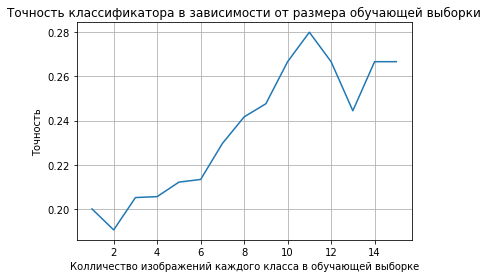

In [217]:
fig, ax = plt.subplots()
ax.set_title('Точность классификатора в зависимости от размера обучающей выборки')
ax.plot(range(1,16), precision_hist)
ax.grid()
ax.set_xlabel('Колличество изображений каждого класса в обучающей выборке')
ax.set_ylabel('Точность')
plt.show()

### PCA

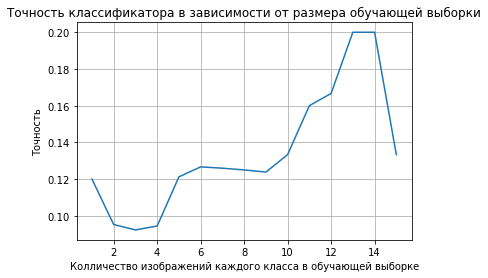

In [218]:
fig, ax = plt.subplots()
ax.set_title('Точность классификатора в зависимости от размера обучающей выборки')
ax.plot(range(1,16), precision_pca)
ax.grid()
ax.set_xlabel('Колличество изображений каждого класса в обучающей выборке')
ax.set_ylabel('Точность')
plt.show()

### Haralick

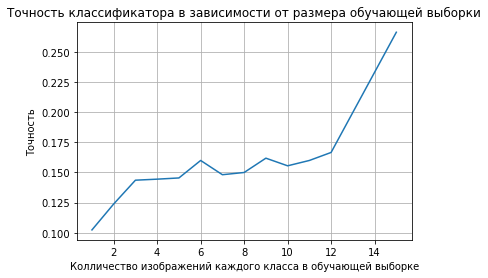

In [219]:
fig, ax = plt.subplots()
ax.set_title('Точность классификатора в зависимости от размера обучающей выборки')
ax.plot(range(1,16), precision_haralick)
ax.grid()
ax.set_xlabel('Колличество изображений каждого класса в обучающей выборке')
ax.set_ylabel('Точность')
plt.show()